In [59]:
import pandas as pd
from isbtchot.model import btc_hist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

In [71]:
df = btc_hist()[["Close"]].rename({"Close":"price"}, axis=1)
YEARS_PREDICTION = 20

# Adjust for genesis block
GENESIS_DELTA = (df.index[0] - pd.Timestamp(year=2009, month=1, day=3)).days
df["days"] = np.arange(len(df)) + GENESIS_DELTA



In [61]:
# Applying log transformation
X_log = np.log(df['days'].values.reshape(-1, 1))
y_log = np.log(df['price'].values)

# Fit the linear regression model on the log-transformed data
power_law_model = LinearRegression().fit(X_log, y_log)

# The coefficient 'b' is the slope of the line in the log-log space
b = power_law_model.coef_[0]
# The coefficient 'a' is obtained by taking the exponential of the intercept in the log-log space
a = np.exp(power_law_model.intercept_)

# Print the model
a, b

(2.7429700692394034e-17, 5.706434941611239)

In [62]:
periods = 365 * YEARS_PREDICTION
df = pd.concat([df, pd.DataFrame(
    {
        "days": np.arange(periods) + df.days.iloc[-1],
    },
    index=pd.date_range(df.index[-1], periods=periods, freq="D")
)])

In [63]:
# Using the power law model to predict prices across the original range of days
df['power_law'] = a * (df['days'] ** b)
df['power_law_bottom'] = df['power_law'] * 0.45
df['power_law_top'] = df['power_law'] * 3
df["delta"] = df.price / df.power_law

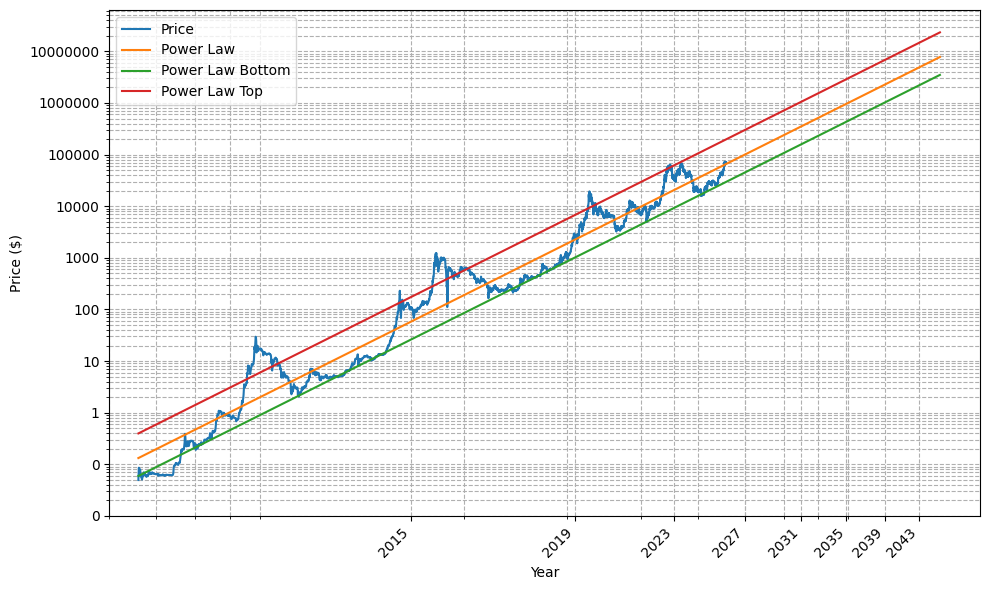

In [64]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot both 'price' and 'power_law' on a log-log scale
plt.plot(df['days'], df['price'], label='Price')
plt.plot(df['days'], df['power_law'], label='Power Law')
plt.plot(df['days'], df['power_law_bottom'], label='Power Law Bottom')
plt.plot(df['days'], df['power_law_top'], label='Power Law Top')

# Setting log scale for both x and y axis
plt.xscale('log')
plt.yscale('log')

# Find the date range
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4YS')

# Calculate the number of days since the start for each year start
xticks_yearly = [(date - df.index.min()).days for date in date_range]

# Generate yearly labels from the date_range
xticklabels_yearly = [date.strftime('%Y') for date in date_range]

# Setting ticks on the x-axis to correspond to the start of each year
plt.xticks(ticks=xticks_yearly, labels=xticklabels_yearly, rotation=45, ha='right')

# Setting the axis labels
plt.xlabel('Year')
plt.ylabel('Price ($)')

# Set the formatter for the y-axis to plain (no scientific notation)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Adding legend and grid
plt.legend()
plt.grid(True, which="both", ls="--")

# Adding limits
plt.xlim(left=500)
plt.ylim(bottom=0.01)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

In [65]:
df.dropna().tail(1)

,price,days,power_law,power_law_bottom,power_law_top,delta
2024-04-11,70729.77,5577,65586.221544,29513.799695,196758.664632,1.078424


In [66]:
df.loc[pd.Timestamp(year=2025, month=1, day=25)]


price                         NaN
days                  5866.000000
power_law            87502.379680
power_law_bottom     39376.070856
power_law_top       262507.139041
delta                         NaN
Name: 2025-01-25 00:00:00, dtype: float64

In [67]:
df[df.power_law > 1_000_000].head(1)

,price,days,power_law,power_law_bottom,power_law_top,delta
2033-08-15,NaN,8990,1.000215e+06,450096.916916,3.000646e+06,NaN


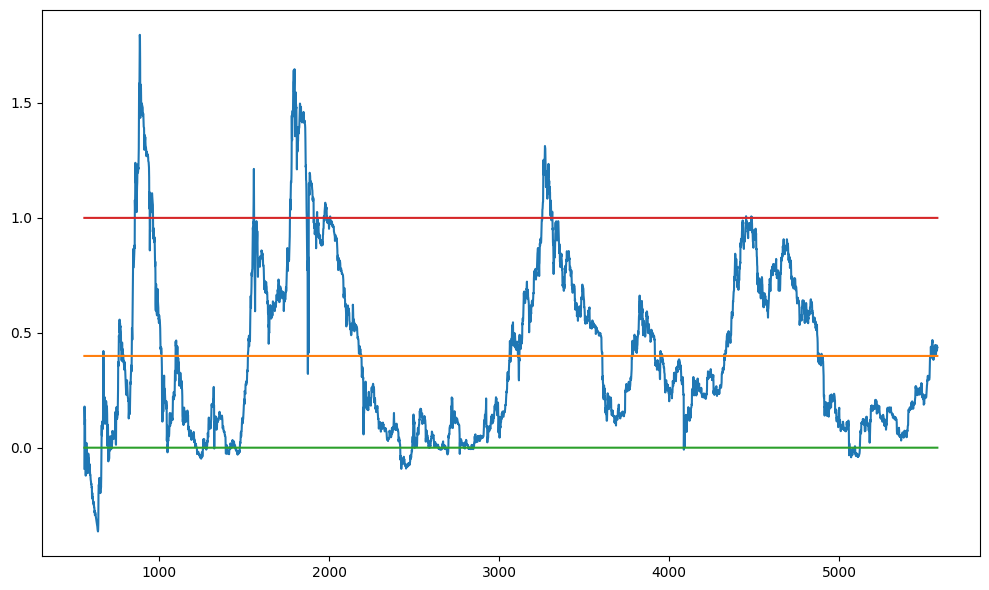

In [68]:
delta = (np.log(df["delta"].dropna()) - np.log(0.45)) / 2
days = df["days"][:len(delta)]

plt.figure(figsize=(10, 6))

# Plot data
plt.plot(days, delta, label='Delta')
plt.plot(days,[(0 - np.log(0.45)) / 2 for _ in delta])
plt.plot(days,[0 for _ in delta])
plt.plot(days,[1 for _ in delta])

# Show the plot
plt.tight_layout()
plt.show()

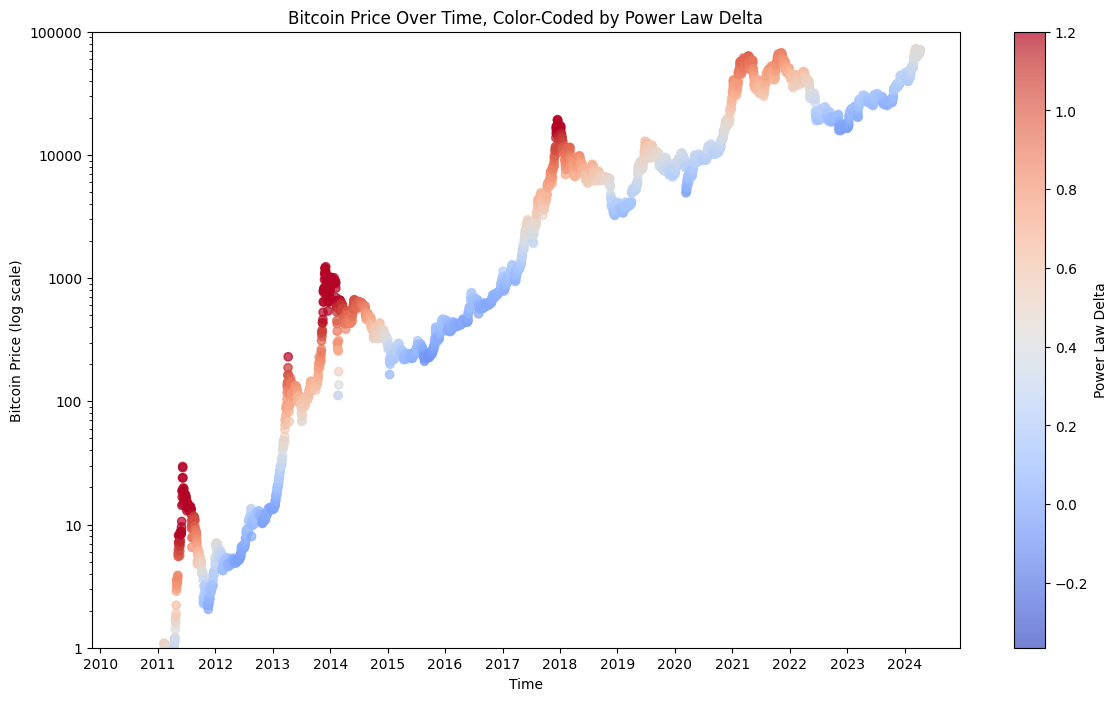

In [69]:
# Parse the dates in the format provided (day/month/year)
df['time'] = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(14, 8))

# Scatter plot for Bitcoin price
sc = ax.scatter(df['time'], df['price'], c=((np.log(df["delta"]) - np.log(0.45)) / 2).clip(upper=1.2), cmap="coolwarm", alpha=0.7)

# Log scale for the price
ax.set_yscale('log')
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_ylim([1, 100_000])

# Set the x-axis to only show the years as labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add color bar to the right of the plot
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Power Law Delta')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Bitcoin Price (log scale)')
ax.set_title('Bitcoin Price Over Time, Color-Coded by Power Law Delta')

plt.show()

Current:
 2024-04-11    0.075501
Name: delta, dtype: float64


<Axes: >

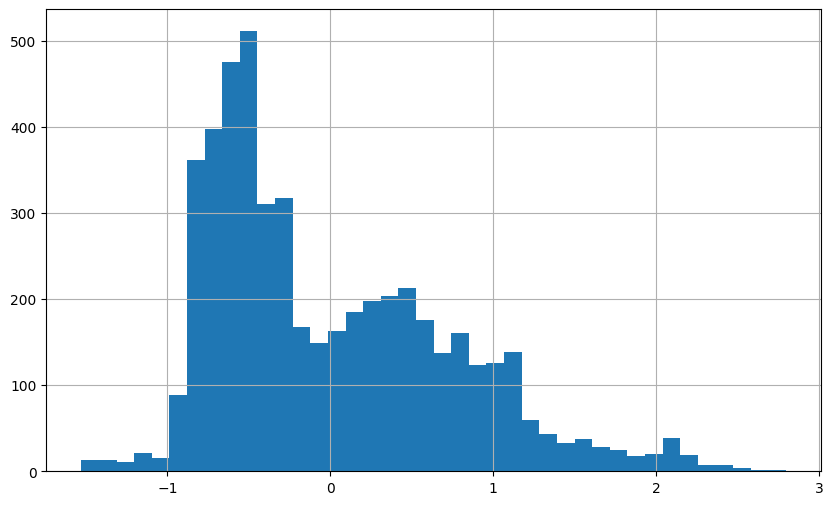

In [70]:
print("Current:\n", np.log(df.dropna().tail(1).delta))
plt.figure(figsize=(10, 6))

np.log(df.delta).hist(bins=40)